In [1]:
import numpy as np
import gurobipy as gp
import pickle
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import gurobipy as gp
import pickle
from gurobipy import GRB
import metrics as M

from crew import Crew
from aceei import ACEEI
gp.setParam('LogToConsole', 0)


Set parameter Username
Set parameter LicenseID to value 2717834
Academic license - for non-commercial use only - expires 2026-10-03
Set parameter LogToConsole to value 0


In [2]:
def check_eftb_sanity(bundles, utilities, budgets0, prices, mode="contested"):
    """
    bundles: dict i -> np.array of 0/1 allocations
    utilities: dict i -> np.array of utilities
    budgets0: dict i -> float (priority budget)
    prices: np.array of prices
    mode: "classic" or "contested"
    """

    violations = []
    free_mask = (prices < 1e-6).astype(int)

    agent_ids = list(bundles.keys())

    for i in agent_ids:
        for ip in agent_ids:
            if i == ip:
                continue

            # EF-TB only cares when i has higher priority
            if budgets0[i] <= budgets0[ip]:
                continue

            bundle_i = bundles[i]
            bundle_ip = bundles[ip]

            # --- contested or classic super-bundle ---
            if mode == "contested":
                S = np.maximum(bundle_ip, free_mask)
            else:
                S = bundle_ip

            # utility calculations
            u_i_self = utilities[i] @ bundle_i
            u_i_S = utilities[i] @ S

            # price check
            cost_S = prices @ S
            budget_i = budgets0[i]

            # EF-TB violation
            if (u_i_S > u_i_self) and (cost_S <= budget_i + 1e-9):
                violations.append((i, ip, u_i_self, u_i_S, cost_S))

    return violations


In [3]:
def preference_generator(rng, num_agents, num_features):
    """
    Generate positive-only, heterogeneous agent preferences.
    Produces stable tatonnement behavior and avoids agents wanting nothing.
    """
    
    # --- Step 1: Define heterogeneous preference clusters ---
    cluster_centers = np.array([
        [1.2, 0.6, 0.8],   # Type A: CH-heavy, also likes other features
        [0.8, 1.4, 0.5],   # Type B: overnight-like (if relevant later)
        [0.5, 0.7, 1.8],   # Type C: strongly credit-hour oriented
        [1.0, 1.0, 1.0],   # Type D: balanced
        [0.4, 1.6, 0.6],   # Type E: prefers fewer legs, more rest
    ])
    
    K = cluster_centers.shape[0]

    # --- Step 2: Assign agent types ---
    assignments = rng.integers(0, K, size=num_agents)

    # --- Step 3: Add relatively large noise to diversify preferences ---
    noise = rng.normal(0, 0.4, size=(num_agents, num_features))

    W = cluster_centers[assignments] + noise

    # --- Step 4: Enforce positivity ---
    # Replace any negative weights with small positive values
    W = np.clip(W, a_min=0.05, a_max=None)

    # --- Step 5: Normalize for stability ---
    W = W / np.linalg.norm(W, axis=1, keepdims=True)

    return W


In [4]:
def compute_conflicts_from_spans(spans):
    """
    spans: dict mapping item j -> (start_j, end_j)  or dict with keys
           'start','end'.

    Returns: list of tuples (j,k) meaning pairings j and k overlap.
    """
    conflicts = []
    items = list(spans.keys())

    def get_times(s):
        if isinstance(s, tuple) or isinstance(s, list):
            return s[0], s[1]
        return s["start"], s["end"]

    for i in range(len(items)):
        j = items[i]
        start_j, end_j = get_times(spans[j])

        for k in items[i+1:]:
            start_k, end_k = get_times(spans[k])

            # overlap test
            if not (end_j <= start_k or end_k <= start_j):
                conflicts.append((j, k))

    return conflicts


In [5]:
def verify_no_conflicts(bundle, spans):
    """
    bundle: array-like of 0/1 decisions for each pairing j
    spans: dict mapping j -> (start_j, end_j) OR dict with keys {'start','end'}

    Returns:
        (ok, conflicts)
        ok = True if conflict-free, False otherwise
        conflicts = list of conflicting pairs (j,k)
    """

    # identify selected items
    selected = [j for j in range(len(bundle)) if bundle[j] == 1]

    def get_times(span):
        if isinstance(span, tuple) or isinstance(span, list):
            return span[0], span[1]
        return span["start"], span["end"]

    conflicts = []

    # brute-force O(n^2) over selected items (small in practice)
    for i in range(len(selected)):
        j = selected[i]
        sj, ej = get_times(spans[j])

        for k in selected[i+1:]:
            sk, ek = get_times(spans[k])

            # overlap test
            if not (ej <= sk or ek <= sj):
                conflicts.append((j, k))

    ok = (len(conflicts) == 0)
    return ok, conflicts


In [30]:
with open('pairings.pickle', 'rb') as f:
    pairings = pickle.load(f)

with open('spans.pickle', 'rb') as f:
    spans = pickle.load(f)

clean_pairings = {}
clean_spans = {}
NUM_PAIRINGS = 120

for i, (id, pairing) in enumerate(pairings.items()):
    if i < NUM_PAIRINGS:
        clean_pairings[i] = pairing
        clean_spans[i] = spans[id]

pairings = clean_pairings
spans = clean_spans

conflicts = compute_conflicts_from_spans(spans) 

NUM_CREWS = 30
NUM_FEATURES = 3
NUM_PAIRINGS = len(pairings)


F = np.zeros((NUM_FEATURES, NUM_PAIRINGS))

# create feature matrix
for id, pairing in pairings.items():
    num_legs = pairing["length"]
    overnights = pairing["overnights"]
    credit_hours = pairing["flight_time"]
    features = np.array([num_legs, overnights, credit_hours])
    F[:, id] = features

# normalize by row
for i in range(NUM_FEATURES):
    F[i, :] = F[i, :] / np.linalg.norm(F[i, :], ord=2)

W = preference_generator(rng=np.random.default_rng(), num_agents=NUM_CREWS, num_features=NUM_FEATURES)
U = W @ F
P = np.argsort(-U, axis=1)

In [31]:
base = 1.0
epsilon = 0.1  
budgets = np.linspace(1, 1.1, num=NUM_CREWS)

In [ ]:
agents = [Crew(id=i, utilities=U[i, :], budget0=budgets[i], conflicts=conflicts) for i in range(NUM_CREWS)]
items = list(pairings.keys())

aceei = ACEEI(agents, np.ones(len(items)), np.array(budgets), epsilon=0.05, delta=0.005, t=2, tol=0)

prices, b, bundles = aceei.run()

Set parameter Username
Set parameter LicenseID to value 2717834
Academic license - for non-commercial use only - expires 2026-10-03
Set parameter Username
Set parameter LicenseID to value 2717834
Set parameter Username
Set parameter LicenseID to value 2717834
Academic license - for non-commercial use only - expires 2026-10-03
Academic license - for non-commercial use only - expires 2026-10-03
Set parameter Username
Set parameter LicenseID to value 2717834
Set parameter Username
Set parameter LicenseID to value 2717834
Academic license - for non-commercial use only - expires 2026-10-03
Academic license - for non-commercial use only - expires 2026-10-03
Set parameter Username
Set parameter LicenseID to value 2717834
Academic license - for non-commercial use only - expires 2026-10-03
Set parameter Username
Set parameter LicenseID to value 2717834
Set parameter Username
Set parameter LicenseID to value 2717834
Academic license - for non-commercial use only - expires 2026-10-03
Academic lic

Process SpawnPoolWorker-1104:
Process SpawnPoolWorker-1103:
Process SpawnPoolWorker-1102:
Process SpawnPoolWorker-1099:
Process SpawnPoolWorker-1098:
Process SpawnPoolWorker-1072:
Process SpawnPoolWorker-1097:
Process SpawnPoolWorker-1095:
Process SpawnPoolWorker-1094:
Process SpawnPoolWorker-1093:
Process SpawnPoolWorker-1092:
Process SpawnPoolWorker-1090:
Process SpawnPoolWorker-1091:
Process SpawnPoolWorker-1088:
Process SpawnPoolWorker-1087:
Process SpawnPoolWorker-1086:
Process SpawnPoolWorker-1084:
Process SpawnPoolWorker-1083:
Process SpawnPoolWorker-1085:
Process SpawnPoolWorker-893:
Process SpawnPoolWorker-892:
Process SpawnPoolWorker-891:
Process SpawnPoolWorker-1081:
Process SpawnPoolWorker-1080:
Process SpawnPoolWorker-1079:
Process SpawnPoolWorker-1101:
Process SpawnPoolWorker-889:
Process SpawnPoolWorker-1078:
Process SpawnPoolWorker-1077:
Process SpawnPoolWorker-1075:
Process SpawnPoolWorker-888:
Process SpawnPoolWorker-887:
Process SpawnPoolWorker-1074:
Process SpawnPoo

Set parameter Username
Set parameter LicenseID to value 2717834
Academic license - for non-commercial use only - expires 2026-10-03
Set parameter Username
Set parameter LicenseID to value 2717834
Set parameter Username
Set parameter LicenseID to value 2717834
Academic license - for non-commercial use only - expires 2026-10-03
Set parameter Username
Set parameter LicenseID to value 2717834
Set parameter Username
Set parameter LicenseID to value 2717834
Academic license - for non-commercial use only - expires 2026-10-03
Set parameter Username
Set parameter LicenseID to value 2717834
Academic license - for non-commercial use only - expires 2026-10-03
Set parameter Username
Set parameter LicenseID to value 2717834
Academic license - for non-commercial use only - expires 2026-10-03
Academic license - for non-commercial use only - expires 2026-10-03
Set parameter Username
Set parameter LicenseID to value 2717834
Academic license - for non-commercial use only - expires 2026-10-03
Set paramete

KeyboardInterrupt: 

Set parameter Username
Set parameter LicenseID to value 2717834
Academic license - for non-commercial use only - expires 2026-10-03
Academic license - for non-commercial use only - expires 2026-10-03
Set parameter Username
Set parameter LicenseID to value 2717834
Set parameter Username
Set parameter LicenseID to value 2717834
Academic license - for non-commercial use only - expires 2026-10-03
Academic license - for non-commercial use only - expires 2026-10-03
Academic license - for non-commercial use only - expires 2026-10-03
Set parameter Username
Set parameter LicenseID to value 2717834
Academic license - for non-commercial use only - expires 2026-10-03
Academic license - for non-commercial use only - expires 2026-10-03
Set parameter Username
Set parameter LicenseID to value 2717834
Academic license - for non-commercial use only - expires 2026-10-03
Academic license - for non-commercial use only - expires 2026-10-03
Set parameter Username
Set parameter LicenseID to value 2717834
Acad

Set parameter Username
Set parameter LicenseID to value 2717834
Academic license - for non-commercial use only - expires 2026-10-03
Set parameter Username
Set parameter LicenseID to value 2717834
Academic license - for non-commercial use only - expires 2026-10-03
Academic license - for non-commercial use only - expires 2026-10-03
Academic license - for non-commercial use only - expires 2026-10-03
Set parameter Username
Set parameter LicenseID to value 2717834
Academic license - for non-commercial use only - expires 2026-10-03
Set parameter Username
Set parameter LicenseID to value 2717834
Set parameter Username
Set parameter LicenseID to value 2717834
Set parameter Username
Set parameter LicenseID to value 2717834
Academic license - for non-commercial use only - expires 2026-10-03
Set parameter Username
Set parameter LicenseID to value 2717834
Set parameter Username
Academic license - for non-commercial use only - expires 2026-10-03
Set parameter LicenseID to value 2717834
Academic lic

In [23]:
print(f'Bundles:{bundles}')
print(f'Prices: {prices}')
print(f'Conflicts: {conflicts}')
for agent in agents:
    print(f'Utilities for agent {agent.id}:')
    print(agent.utilities)

Bundles:{0: array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0]), 1: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0]), 2: array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0]), 3: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0]), 4: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0]), 5: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0]), 6: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0]), 7: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1]), 8: array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0]), 9: array([

Process SpawnPoolWorker-35:


In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def plot_allocation_bipartite_pretty(bundles, prices=None, figsize=(14, 8)):

    agent_ids = sorted(bundles.keys())
    m = len(bundles[agent_ids[0]])

    B = nx.Graph()

    B.add_nodes_from([f"A{a}" for a in agent_ids], bipartite=0)
    B.add_nodes_from([f"I{j}" for j in range(m)], bipartite=1)

    for a, bundle in bundles.items():
        for j, x in enumerate(bundle):
            if x == 1:
                B.add_edge(f"A{a}", f"I{j}")

    # --- Improved layout ---
    x_agent, x_item = 0, 5
    y_agents = np.linspace(0, -len(agent_ids)+1, len(agent_ids))
    y_items = np.linspace(0, -len(agent_ids)+1, m)  # match agent height

    pos = {}
    for idx, a in enumerate(agent_ids):
        pos[f"A{a}"] = (x_agent, y_agents[idx])
    for j in range(m):
        pos[f"I{j}"] = (x_item, y_items[j])

    # --- Colors ---
    agent_color = sns.color_palette("Blues", 6)[3]
    item_color = sns.color_palette("Greens", 6)[3]

    plt.figure(figsize=figsize)

    nx.draw_networkx_nodes(B, pos, 
                           [f"A{a}" for a in agent_ids],
                           node_color=agent_color, node_size=800)
    nx.draw_networkx_nodes(B, pos, 
                           [f"I{j}" for j in range(m)],
                           node_color=item_color, node_size=600)

    # Curved edges help readability
    nx.draw_networkx_edges(B, pos, alpha=0.5, connectionstyle="arc3, rad=0.2")

    nx.draw_networkx_labels(B, pos, font_size=10)

    plt.axis("off")
    plt.title("A-CEEI Allocation")
    plt.show()


/var/folders/7_/y4vpj6ln7b90djzq_hscbgyr0000gn/T/ipykernel_95121/3211423748.py:46: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default values.
Note that using FancyArrowPatches may be slow for large graphs.

  nx.draw_networkx_edges(B, pos, alpha=0.5, connectionstyle="arc3, rad=0.2")


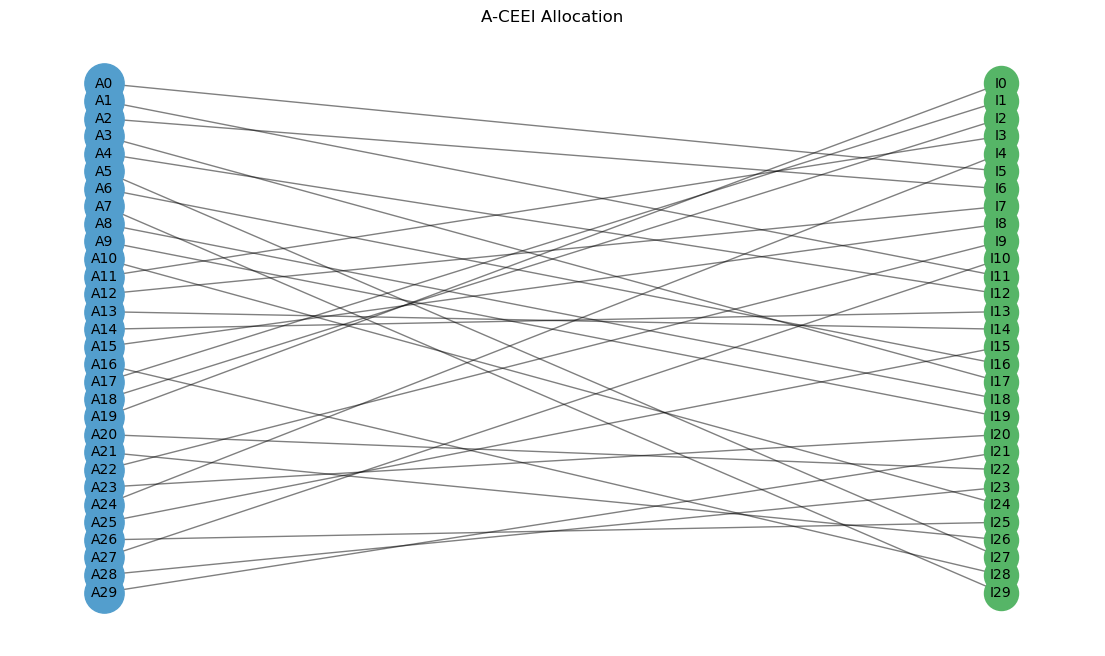

In [29]:
plot_allocation_bipartite_pretty(bundles, prices=None, figsize=(14, 8))

In [27]:
import sd as SD

In [41]:
lines = {}

for id, data in bundles.items():
    lines[id] = data


In [87]:
all_utilities = []

for agent, bundle in bundles.items():
    agent_utility = agents[agent].utilities @ bundle
    all_utilities.append(agent_utility)

print(np.sum(all_utilities))
print(M.gini(all_utilities))

8.743092324404618
0.0472507714917479


In [ ]:
available_lines = set(lines.keys())
matching = {}

all_utilities = []
for crew in np.arange(NUM_CREWS-1, -1, -1):
    utilities = agents[crew].utilities

    line_utilities = np.array([utilities @ line for _, line in lines.items()])

    for line in np.argsort(-line_utilities):
        if line in available_lines:
            matching[crew] = line
            all_utilities.append(line_utilities[line])
            available_lines.remove(line)
            break

all_utilities.reverse()
print(np.sum(all_utilities))
print(M.gini(all_utilities))

8.664997524646722
0.04899750767064426
